<a href="https://colab.research.google.com/github/vrmusketeers/DeepLearningProject/blob/main/notebooks/Generate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download CubiCasa dataset

Downloading the dataset

In [ ]:
# !wget https://zenodo.org/record/2613548/files/cubicasa5k.zip

In [ ]:
# ! cp /content/cubicasa5k.zip '/content/drive/MyDrive/CMPE 258 Deep Learning/Data Prep CubiCasa/cubicasa5k.zip'

In [ ]:
!unzip '/content/drive/MyDrive/CMPE 258 Deep Learning/Data Prep CubiCasa/cubicasa5k.zip' -d /content

Streaming output truncated to the last 5000 lines.
   creating: /content/cubicasa5k/high_quality_architectural/4014/
  inflating: /content/cubicasa5k/high_quality_architectural/4014/F1_scaled.png  
  inflating: /content/cubicasa5k/high_quality_architectural/4014/F1_original.png  
  inflating: /content/cubicasa5k/high_quality_architectural/4014/model.svg  
   creating: /content/cubicasa5k/high_quality_architectural/14296/
  inflating: /content/cubicasa5k/high_quality_architectural/14296/F1_scaled.png  
  inflating: /content/cubicasa5k/high_quality_architectural/14296/F1_original.png  
  inflating: /content/cubicasa5k/high_quality_architectural/14296/model.svg  
   creating: /content/cubicasa5k/high_quality_architectural/14295/
  inflating: /content/cubicasa5k/high_quality_architectural/14295/F2_scaled.png  
  inflating: /content/cubicasa5k/high_quality_architectural/14295/F1_scaled.png  
  inflating: /content/cubicasa5k/high_quality_architectural/14295/F1_original.png  
  inflating: /co

# Setup code to process SVGs into annotated images

## Use dataset util methods to load SVGs

In [ ]:
!git clone https://github.com/CubiCasa/CubiCasa5k.git

Cloning into 'CubiCasa5k'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 120 (delta 43), reused 37 (delta 35), pack-reused 52 (from 1)
Receiving objects: 100% (120/120), 62.49 MiB | 23.61 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
!pip install svgpathtools num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=0b34b1cd1f83b82c31239b40f811368bd6831a0cd336009ef40f97062dbaf362
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!mv /content/CubiCasa5k /content/CubiCasaSource
!touch /content/CubiCasaSource/__init__.py

In [ ]:
!pip install lmdb==1.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('/content/CubiCasaSource')

from skimage import transform
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns, svg_utils
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid
from num2words import num2words
from xml.dom import minidom

/content/CubiCasaSource/floortrans/loaders/svg_utils.py:565: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direction is 'H':
/content/CubiCasaSource/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4
/content/CubiCasaSource/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4


## Setup floorplan color schemes

In [ ]:
BACKGROUND_COLOR = '#f2f2f2'

legend = [
  {'region_name': 'Background', 'c': BACKGROUND_COLOR, 'shouldInclude': True},
  {'region_name': 'Yard', 'c': '#b3de69', 'shouldInclude': True},
  {'region_name': 'Wall', 'c': '#000000', 'shouldInclude': True},
  {'region_name': 'Kitchen', 'c': '#8dd3c7', 'shouldInclude': True},
  {'region_name': 'Living Room', 'c': '#fdb462', 'shouldInclude': True},
  {'region_name': 'Bedroom', 'c': '#fccde5', 'shouldInclude': True},
  {'region_name': 'Bathroom', 'c': '#80b1d3', 'shouldInclude': True},
  {'region_name': 'Hallway', 'c': '#808080', 'shouldInclude': True},
  {'region_name': 'Railing', 'c': '#663300', 'shouldInclude': False},
  {'region_name': 'Storage room', 'c': '#cc99ff', 'shouldInclude': True},
  {'region_name': 'Garage', 'c': '#577a4d', 'shouldInclude': True},
  {'region_name': 'Other room', 'c': '#ffffb3', 'shouldInclude': True},
  {'region_name': 'No Furnishing', 'c': '#351f13', 'shouldInclude': False},
  {'region_name': 'Window', 'c': '#d5f5fb', 'shouldInclude': True},
  {'region_name': 'Door', 'c': '#cc6600', 'shouldInclude': True},
  {'region_name': 'Closet', 'c': '#ff6666', 'shouldInclude': True},
  {'region_name': 'Electrical Appliance', 'c': '#999900', 'shouldInclude': True},
  {'region_name': 'Toilet', 'c': '#eeeeee', 'shouldInclude': True},
  {'region_name': 'Sink', 'c': '#eeeeee', 'shouldInclude': True},
  {'region_name': 'Sauna Bench', 'c': '#7588c4', 'shouldInclude': True},
  {'region_name': 'Fireplace', 'c': '#cc0000', 'shouldInclude': True},
  {'region_name': 'Bathtub', 'c': '#00d6a4', 'shouldInclude': True},
  {'region_name': 'Chimney', 'c': '#94a4aa', 'shouldInclude': True},
  {'region_name': 'Other furnishing', 'c': '#79847e', 'shouldInclude': False},
]

cpool = [l['c'] if l['shouldInclude'] else BACKGROUND_COLOR for l in legend]
cmap3 = colors.ListedColormap(cpool, 'rooms_test')
cm.register_cmap(cmap=cmap3)

# NUM_ROOM_TYPES = 12
NUM_ROOM_TYPES = sum(1 for l in legend if l['shouldInclude'])
print(NUM_ROOM_TYPES)

21


<ipython-input-10-1944fa4738be>:32: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap(cmap=cmap3)


In [ ]:
print(len(legend))

24


## Create mapping for room ID to room name

In [ ]:
type(legend)

list

In [ ]:
rooms_selected = {"Alcove": 11,
                  "Attic": 11,
                  "Ballroom": 11,
                  "Bar": 11,
                  "Basement": 11,
                  "Bath": 6,
                  "Bedroom": 5,
                  "CarPort": 10,
                  "Church": 11,
                  "Closet": 9,
                  "ConferenceRoom": 11,
                  "Conservatory": 11,
                  "Counter": 11,
                  "Den": 11,
                  "Dining": 4,
                  "DraughtLobby": 7,
                  "DressingRoom": 9,
                  "EatingArea": 4,
                  "Elevated": 11,
                  "Elevator": 11,
                  "Entry": 7,
                  "ExerciseRoom": 11,
                  "Garage": 10,
                  "Garbage": 11,
                  "Hall": 11,
                  "HallWay": 7,
                  "HotTub": 11,
                  "Kitchen": 3,
                  "Library": 11,
                  "LivingRoom": 4,
                  "Loft": 11,
                  "Lounge": 4,
                  "MediaRoom": 11,
                  "MeetingRoom": 11,
                  "Museum": 11,
                  "Nook": 11,
                  "Office": 11,
                  "OpenToBelow": 11,
                  "Outdoor": 1,
                  "Pantry": 11,
                  "Reception": 11,
                  "RecreationRoom": 11,
                  "RetailSpace": 11,
                  "Room": 11,
                  "Sanctuary": 11,
                  "Sauna": 6,
                  "ServiceRoom": 11,
                  "ServingArea": 11,
                  "Skylights": 11,
                  "Stable": 11,
                  "Stage": 11,
                  "StairWell": 11,
                  "Storage": 9,
                  "SunRoom": 11,
                  "SwimmingPool": 11,
                  "TechnicalRoom": 11,
                  "Theatre": 11,
                  "Undefined": 11,
                  "UserDefined": 11,
                  "Utility": 11,
                  "Background": 0,  # Not in data. The default outside label
                  "Wall": 2,
                  "Railing": 8}
icons_selected = {"Window": 1,
                  "Door": 2,
                  "Closet": 3,
                  "ClosetRound": 3,
                  "ClosetTriangle": 3,
                  "CoatCloset": 3,
                  "CoatRack": 3,
                  "CounterTop": 3,
                  "Housing": 3,
                  "ElectricalAppliance": 4,
                  "WoodStove": 4,
                  "GasStove": 4,
                  "Toilet": 5,
                  "Urinal": 5,
                  "SideSink": 6,
                  "Sink": 6,
                  "RoundSink": 6,
                  "CornerSink": 6,
                  "DoubleSink": 6,
                  "DoubleSinkRight": 6,
                  "WaterTap": 6,
                  "SaunaBenchHigh": 7,
                  "SaunaBenchLow": 7,
                  "SaunaBenchMid": 7,
                  "SaunaBench": 7,
                  "Fireplace": 8,
                  "FireplaceCorner": 8,
                  "FireplaceRound": 8,
                  "PlaceForFireplace": 8,
                  "PlaceForFireplaceCorner": 8,
                  "PlaceForFireplaceRound": 8,
                  "Bathtub": 9,
                  "BathtubRound": 9,
                  "Chimney": 10,
                  "Misc": 0,
                  "BaseCabinetRound": 0,
                  "BaseCabinetTriangle": 0,
                  "BaseCabinet": 0,
                  "WallCabinet": 0,
                  "Shower": 0,
                  "ShowerCab": 0,
                  "ShowerPlatform": 0,
                  "ShowerScreen": 0,
                  "ShowerScreenRoundRight": 0,
                  "ShowerScreenRoundLeft": 0,
                  "Jacuzzi": 0
                  }

rooms = {}
for key, val in rooms_selected.items():
  rooms[val] = rooms.get(val, []) + [key]

furniture = {}
for key, val in icons_selected.items():
  furniture[val + NUM_ROOM_TYPES] = furniture.get(val + NUM_ROOM_TYPES, []) + [key]

combined_legend  = {**rooms, **furniture}
combined_legend

{11: ['Alcove',
  'Attic',
  'Ballroom',
  'Bar',
  'Basement',
  'Church',
  'ConferenceRoom',
  'Conservatory',
  'Counter',
  'Den',
  'Elevated',
  'Elevator',
  'ExerciseRoom',
  'Garbage',
  'Hall',
  'HotTub',
  'Library',
  'Loft',
  'MediaRoom',
  'MeetingRoom',
  'Museum',
  'Nook',
  'Office',
  'OpenToBelow',
  'Pantry',
  'Reception',
  'RecreationRoom',
  'RetailSpace',
  'Room',
  'Sanctuary',
  'ServiceRoom',
  'ServingArea',
  'Skylights',
  'Stable',
  'Stage',
  'StairWell',
  'SunRoom',
  'SwimmingPool',
  'TechnicalRoom',
  'Theatre',
  'Undefined',
  'UserDefined',
  'Utility'],
 6: ['Bath', 'Sauna'],
 5: ['Bedroom'],
 10: ['CarPort', 'Garage'],
 9: ['Closet', 'DressingRoom', 'Storage'],
 4: ['Dining', 'EatingArea', 'LivingRoom', 'Lounge'],
 7: ['DraughtLobby', 'Entry', 'HallWay'],
 3: ['Kitchen'],
 1: ['Outdoor'],
 0: ['Background'],
 2: ['Wall'],
 8: ['Railing'],
 22: ['Window'],
 23: ['Door'],
 24: ['Closet',
  'ClosetRound',
  'ClosetTriangle',
  'CoatCloset',

## Create util methods to parse SVG and color rooms
* Parse floorplan SVG for different floors and room regions
* Create text description for each house's floorplan based on the number floors and room regions present
* Integrates above `get_regions` and `generate_floorplan_description` given folder to generate data from floorplan SVGs
* Save generated image processed from SVG

# Generate images for dataset

In [ ]:
# Parse floorplan SVG for different floors and room regions
def get_regions(root_dir, instance_dir):
  path = root_dir + '/' + instance_dir + '/model.svg'
  svg = minidom.parse(path)
  house = {}

  for component in svg.getElementsByTagName('g'):
    floor_elem = component.getAttribute("class")
    if "Floorplan " in component.getAttribute("class"):
      floor_num = int(component.getAttribute("class").split(" ")[1].split('-')[1])
      house[floor_num] = house.get(floor_num, {})

      for e in component.getElementsByTagName('g'):
        if "Space " in e.getAttribute("class"):
          name_list = e.getAttribute("class").split(" ")
          room_type = name_list[1]
          index = svg_utils.get_room_number(e, rooms_selected)
          print(type(index), index)
          region_name = legend[int(index)]['region_name']
          house[floor_num][region_name] = house[floor_num].get(region_name, 0) + 1
  return house

# Create text description for each house's floorplan based on the number floors and room regions present
def generate_floorplan_description(house):
  num_floors = len(house.keys())
  s = 'The house has {} floor'.format(num2words(num_floors))
  if num_floors > 1:
    s += 's'
  s += '.'

  for floor in range(1, num_floors + 1):
    s += ' The {} floor has'.format(num2words(floor, to='ordinal'))
    house_floor = house[floor]
    for l in legend:
      room_name = l['region_name']
      if room_name in house_floor and l['shouldInclude']:
        s += ' {} {}'.format(num2words(house_floor[room_name]), room_name.lower())
        if house_floor[room_name] > 1:
          s += 's'

    s += '.'

  return s

# Integrates above get_regions and generate_floorplan_description given folder to generate data from floorplan SVGs
def get_text(root_dir, instance_folder):
  house = get_regions(root_dir, instance_folder)
  return len(house.keys()), generate_floorplan_description(house)

# Save generated image processed from SVG
def gen_annotated_img(label, save_path):
  label_np = label.data.numpy()[0]
  new_label_np = np.where(label_np[1] != 0,  label_np[1] + NUM_ROOM_TYPES, label_np[0])

  plt.figure(figsize=(10,10))
  plt.axis('off')
  rseg = plt.imshow(new_label_np, cmap='rooms_test', vmin=0, vmax=len(legend)-0.1)
  plt.savefig(save_path)
  plt.clf()

## Load data

In [ ]:
data_folder = '/content/cubicasa5k/'
data_file = 'train.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)

In [ ]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image']
label = val['label']

file_id = folder.split('/')[2]
instance_dir = '/high_quality_architectural/{}'.format(file_id)
print(instance_dir)

/high_quality_architectural/6044


## Render example of generated training data

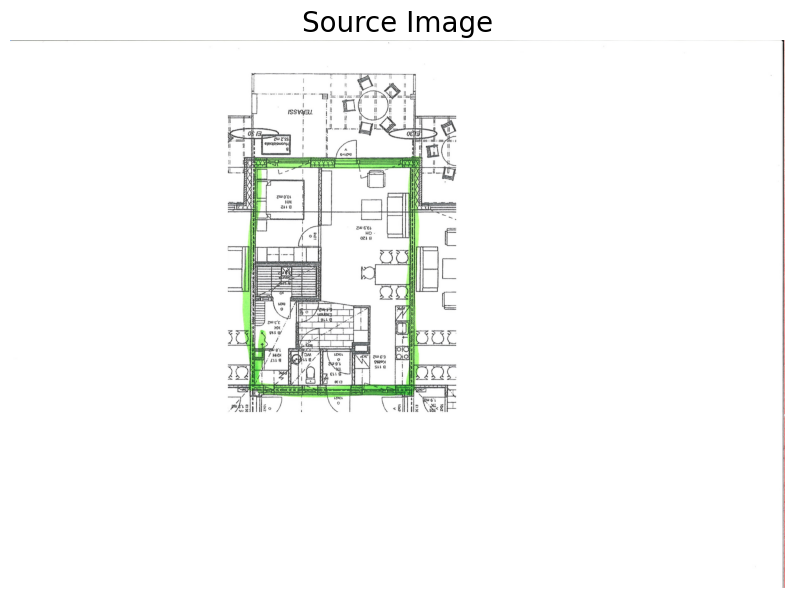

In [ ]:
# Show orig SVG image
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

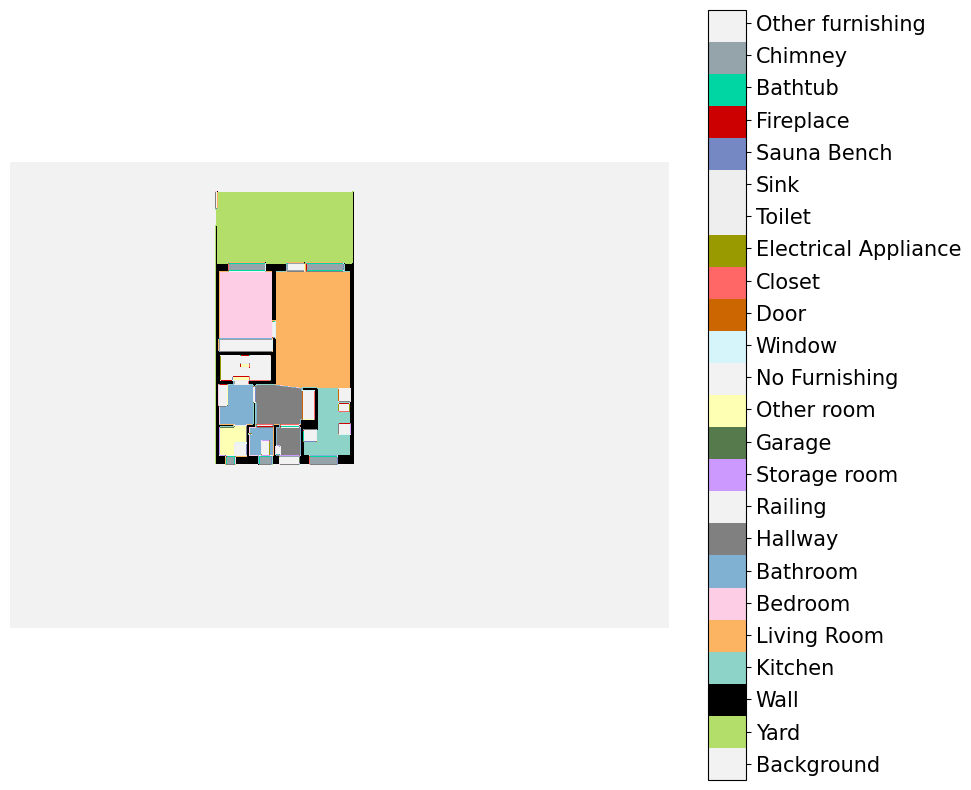

<class 'int'> 1
<class 'int'> 7
<class 'int'> 3
<class 'int'> 4
<class 'int'> 11
<class 'int'> 6
<class 'int'> 5
<class 'int'> 11
<class 'int'> 7
<class 'int'> 6
(1, 'The house has one floor. The first floor has one yard one kitchen one living room one bedroom two bathrooms two hallways two other rooms.')


In [ ]:
# Show generated annotated image to use for training

label_np = label.data.numpy()[0]
new_label_np = np.where(label_np[1] != 0,  label_np[1] + NUM_ROOM_TYPES, label_np[0])

plt.figure(figsize=(10,10))
plt.axis('off')
rseg = plt.imshow(new_label_np, cmap='rooms_test', vmin=0, vmax=len(legend)-0.1)
cbar = plt.colorbar(rseg, ticks=(np.arange(len(legend))+ 0.5 ), fraction=0.1, pad=0.05)
cbar.ax.set_yticklabels([l['region_name'] for l in legend], fontsize=15)
plt.show()

text = get_text(data_folder, instance_dir)
print(text)

## Show SVG as example

In [ ]:
!cat /content/cubicasa5k/{instance_dir}/model.svg

<?xml version="1.0"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" height="1618.8400421142578" version="1.1" width="1730.8900146484375" id="temp" viewBox="0 0 1730.8900146484375 1618.8400421142578"><defs/><g id="Model" class="Model v1-1"><g class="Floor"><g id="Floor-1" class="Floorplan Floor-1"><g id="fa6d7cfb-602b-4da7-8c99-fc19e337c6ab" fill="#ffffff" stroke="#000000" style="fill-opacity: 1; stroke-opacity: 1; stroke-width: 0.2;" class="Space Outdoor Terrace"><polygon points="1030.81,507.29 1030.81,146.67 1719.89,146.67 1719.89,507.29 1030.81,507.29 1030.81,507.29 "/><g transform="matrix(1,0,0,1,1030.8125,146.6672)" class="Dimension"><g transform="matrix(1,0,0,1,0,0)" style="display: none;" class="Visual"><g id="mark1" fill="#000000" stroke="none" transform="matrix(1,0,0,1,344.5363,0)" style="fill-opacity: 1; pointer-events: visible;" class="DimensionMark"><polygon points="-5,5,0,0,5,5"/></g><g id="mark2" fill="#000000" stroke="none" transform="

## Process all SVGs into annotated images with room regions and house text description

In [ ]:
!rm -rf /content/annotated_cubicasa
!mkdir -p /content/annotated_cubicasa

In [ ]:
data_iter = iter(data_loader)
# num_iter = len(data_iter)
num_iter=3500
print(num_iter)
print(data_iter)

3500


In [ ]:
i = 2101
for i in range(num_iter):
  val = next(data_iter)

  if not val:
    print('{}: Error loading'.format(i))
    i += 1
    continue

  folder = val['folder'][0]
  file_id = folder.split('/')[2]
  label = val['label']

  num_floors, text = get_text(data_folder, folder)

  instance_dir = '/content/annotated_cubicasa/{}-Floors/{}'.format(num_floors, file_id)

  if not os.path.isdir(instance_dir):
    pathlib.Path(instance_dir).mkdir(parents=True, exist_ok=True)
  else:
    print('{}: Skipping {}'.format(i, instance_dir))
    i += 1
    continue

  with open('{}/{}.txt'.format(instance_dir, file_id), "w") as file:
    file.write(text)

  gen_annotated_img(label, '{}/{}.jpg'.format(instance_dir, file_id))

  print('{}: Annotated {}'.format(i, file_id))
  i += 1

<class 'int'> 1
<class 'int'> 7
<class 'int'> 3
<class 'int'> 4
<class 'int'> 11
<class 'int'> 6
<class 'int'> 5
<class 'int'> 11
<class 'int'> 7
<class 'int'> 6
0: Annotated 6044
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 1
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 1
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
1: Annotated 2564
<class 'int'> 5
<class 'int'> 3
<class 'int'> 11
<class 'int'> 11
<class 'int'> 5
<class 'int'> 1
2: Annotated 6165
<class 'int'> 1
<class 'int'> 1
<class 'int'> 6
<class 'int'> 7
<class 'int'> 6
<class 'int'> 11
<class 'int'> 11
<class 'int'> 9
<class 'int'> 5
<class 'int'> 7
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 1
<class 'int'> 11
<class 'int'> 11


<ipython-input-14-a6623a986f78>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


Streaming output truncated to the last 5000 lines.
<class 'int'> 3
<class 'int'> 4
<class 'int'> 11
<class 'int'> 4
<class 'int'> 1
<class 'int'> 1
<class 'int'> 1
<class 'int'> 5
<class 'int'> 6
<class 'int'> 5
<class 'int'> 5
<class 'int'> 7
<class 'int'> 11
<class 'int'> 1
650: Annotated 4741
<class 'int'> 1
<class 'int'> 4
<class 'int'> 5
<class 'int'> 11
<class 'int'> 3
<class 'int'> 9
<class 'int'> 6
651: Annotated 6
<class 'int'> 1
<class 'int'> 4
<class 'int'> 3
<class 'int'> 7
<class 'int'> 4
<class 'int'> 5
<class 'int'> 6
<class 'int'> 9
<class 'int'> 11
<class 'int'> 7
652: Annotated 8292
<class 'int'> 1
<class 'int'> 6
<class 'int'> 4
<class 'int'> 11
<class 'int'> 11
<class 'int'> 3
<class 'int'> 9
653: Annotated 1364
<class 'int'> 6
<class 'int'> 3
<class 'int'> 11
<class 'int'> 11
<class 'int'> 4
<class 'int'> 1
654: Annotated 4592
<class 'int'> 1
<class 'int'> 7
<class 'int'> 3
<class 'int'> 4
<class 'int'> 5
<class 'int'> 4
<class 'int'> 5
<class 'int'> 9
<class 'int'

/content/CubiCasaSource/floortrans/loaders/house.py:952: RuntimeWarning: divide by zero encountered in scalar divide
  res = res / float(i)


Streaming output truncated to the last 5000 lines.
1843: Annotated 10659
<class 'int'> 1
<class 'int'> 11
<class 'int'> 7
<class 'int'> 9
<class 'int'> 5
<class 'int'> 3
<class 'int'> 4
<class 'int'> 11
<class 'int'> 11
1844: Annotated 10662
<class 'int'> 1
<class 'int'> 4
<class 'int'> 3
<class 'int'> 7
<class 'int'> 5
<class 'int'> 5
<class 'int'> 6
<class 'int'> 11
<class 'int'> 6
<class 'int'> 9
1845: Annotated 10668
<class 'int'> 11
<class 'int'> 4
<class 'int'> 5
<class 'int'> 3
<class 'int'> 11
<class 'int'> 9
1846: Annotated 10670
<class 'int'> 9
<class 'int'> 11
<class 'int'> 6
<class 'int'> 1
<class 'int'> 5
<class 'int'> 7
<class 'int'> 3
<class 'int'> 4
<class 'int'> 4
1847: Annotated 10672
<class 'int'> 1
<class 'int'> 4
<class 'int'> 5
<class 'int'> 5
<class 'int'> 3
<class 'int'> 11
<class 'int'> 6
1848: Annotated 10678
<class 'int'> 1
<class 'int'> 11
<class 'int'> 11
<class 'int'> 11
<class 'int'> 7
<class 'int'> 4
<class 'int'> 3
1849: Annotated 10685
<class 'int'> 1


In [ ]:
!ls /content/annotated_cubicasa/* | wc -l

# Zip and store results

In [ ]:
!rm /content/annotated_cubicasa.zip
!zip -r /content/annotated_cubicasa.zip /content/annotated_cubicasa

Streaming output truncated to the last 5000 lines.
  adding: content/annotated_cubicasa/1-Floors/1397/1397.txt (deflated 22%)
  adding: content/annotated_cubicasa/1-Floors/10271/ (stored 0%)
  adding: content/annotated_cubicasa/1-Floors/10271/10271.txt (deflated 19%)
  adding: content/annotated_cubicasa/1-Floors/10271/10271.jpg (deflated 81%)
  adding: content/annotated_cubicasa/1-Floors/520/ (stored 0%)
  adding: content/annotated_cubicasa/1-Floors/520/520.txt (deflated 38%)
  adding: content/annotated_cubicasa/1-Floors/520/520.jpg (deflated 58%)
  adding: content/annotated_cubicasa/1-Floors/10491/ (stored 0%)
  adding: content/annotated_cubicasa/1-Floors/10491/10491.jpg (deflated 50%)
  adding: content/annotated_cubicasa/1-Floors/10491/10491.txt (deflated 37%)
  adding: content/annotated_cubicasa/1-Floors/6454/ (stored 0%)
  adding: content/annotated_cubicasa/1-Floors/6454/6454.jpg (deflated 62%)
  adding: content/annotated_cubicasa/1-Floors/6454/6454.txt (deflated 20%)
  adding: con

In [ ]:
# !unzip -l /content/annotated_cubicasa.zip | less

In [ ]:
! cp /content/annotated_cubicasa.zip '/content/drive/MyDrive/CMPE 258 Deep Learning/annotated_cubicasa.zip'